# <center>PROJET FINAL</center> 
## <center>Prévision du cours des actions des fiducies de placement immobilier :</center><center>une comparaison entre divers modèles</center> 

## Introduction
<p style='text-align: justify;'> Nous souhaitons estimer un modèle ARIMA en vue de prédire la valeur mensuelle du cours de l'indice des fiducies de placement immobilier (FPI).
    
Au final, deux modèles ARIMA ont été estimés en utilisant diverses méthodologies :
- Box-Jenkins,
- automatique.

Ensuite, la technique de "rolling forecast" a été appliquée aux deux modèles.

Les modèles estimés ont été comparés sur leur capacité à faire des prévisions au regard de certains critères communément utilisés dans la littérature. Il s’agit notamment des critères Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE). 

Les données sollicitées sont les cours des indices des FPI.</p>

In [1]:
# !pip install matplotlib
# !pip install statsmodels
# !pip install numpy scipy patsy
# !pip install statsforecast
# !pip install pmdarima

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import urllib
import yfinance as yf
import datetime 
import matplotlib.pyplot as plt
import numpy as np
import math


from datetime import date

from pandas import DataFrame
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

from numpy import log
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.stats.stattools import durbin_watson

from pmdarima.arima import auto_arima
from pmdarima.utils import diff_inv

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

# 1. Collecte des données FPI (Fiducie de placements immobiliers)

Le choix de l’année 1993 pour le début des séries n’est pas le fait du hasard car c’est l’année durant laquelle une importante loi (Omnibus Budget Reconciliation Act of 1993) est entrée en vigueur. Comme bien d’autres auteurs, Chan et al. (2003, p. 30) considèrent que cet évènement est à l’origine de la croissance importante que connaîtra le secteur parce que cette loi permettait désormais aux fonds de pension d’investir massivement dans les FPI. Cette période à partir de 1993 est reconnue comme étant l’Ère Moderne des FPI. Elle coïncide avec le fait identifié par certains auteurs selon lequel les actions FPI se comportaient comme les actions ordinaires.

## 1.1 Données prix des indices pour les FPI (All REITs)

In [3]:
dls = "https://www.reit.com/sites/default/files/returns/MonthlyHistoricalReturns.xls"
urllib.request.urlretrieve(dls, "MonthlyHistoricalReturns.xls")

('MonthlyHistoricalReturns.xls', <http.client.HTTPMessage at 0x1713e8c3ef0>)

### Entête du fichier Excel contenant les données des FPI
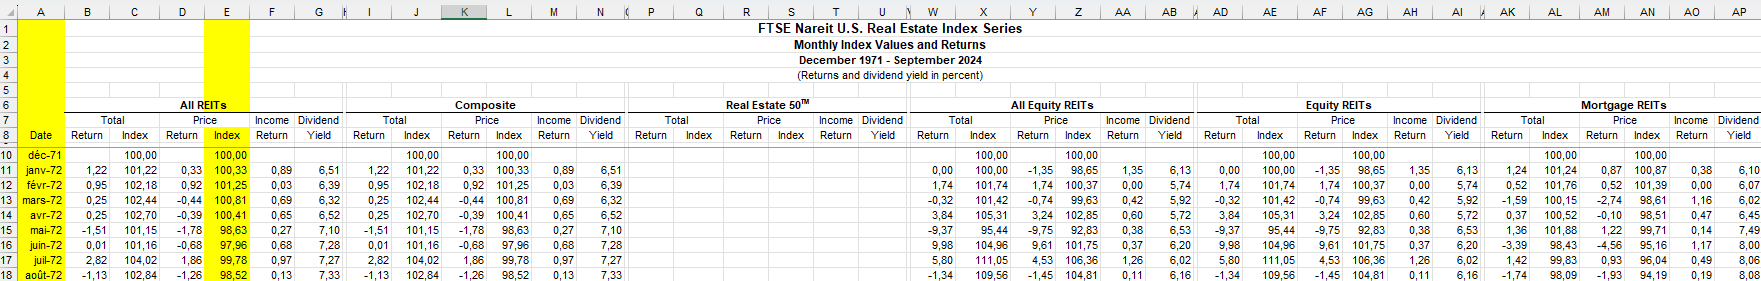

In [4]:
Reits_data = pd.read_excel('MonthlyHistoricalReturns.xls', sheet_name='Index Data', skiprows = 8)
# print(Reits_data)
Reits_data.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,1971-12-31,NaN,100.000000,NaN,100.000000,NaN,NaN,NaN,NaN,100.000000,...,100.000000,NaN,NaN,NaN,NaN,100.000000,NaN,100.000000,NaN,NaN
1,1972-01-31,1.220353,101.220353,0.326895,100.326895,0.893458,6.51,NaN,1.220353,101.220353,...,98.654620,1.346232e+00,6.13,NaN,1.242940,101.242940,0.866344,100.866344,0.376596,6.10
2,1972-02-29,0.949680,102.181621,0.919890,101.249791,0.029790,6.39,NaN,0.949680,102.181621,...,100.368260,-2.664535e-13,5.74,NaN,0.515146,101.764489,0.515146,101.385953,0.000000,6.07
3,1972-03-31,0.252432,102.439561,-0.435933,100.808410,0.688366,6.32,NaN,0.252432,102.439561,...,99.629057,4.204270e-01,5.92,NaN,-1.585718,100.150791,-2.741985,98.605966,1.156267,6.02
4,1972-04-30,0.254852,102.700630,-0.394636,100.410583,0.649488,6.52,NaN,0.254852,102.700630,...,102.853352,6.041510e-01,5.72,NaN,0.367399,100.518745,-0.098529,98.508810,0.465929,6.45


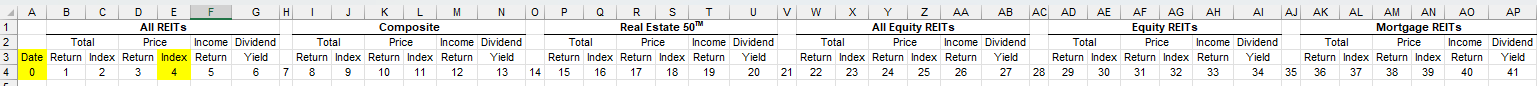

In [5]:
Reits_data = Reits_data.iloc[:, [0, 4]]

In [6]:
Reits_data.head()

,Unnamed: 0,Unnamed: 4
0,1971-12-31,100.000000
1,1972-01-31,100.326895
2,1972-02-29,101.249791
3,1972-03-31,100.808410
4,1972-04-30,100.410583


In [7]:
Reits_data.columns = ["Date", "All_REITs"]

In [8]:
Reits_data.head()

,Date,All_REITs
0,1971-12-31,100.000000
1,1972-01-31,100.326895
2,1972-02-29,101.249791
3,1972-03-31,100.808410
4,1972-04-30,100.410583


In [9]:
# Changer nom colonne
All_REIT = Reits_data.rename(columns={'All_REITs': 'Indice'})

# Ajouter 10 jours
All_REIT['Date'] = All_REIT['Date'] + datetime.timedelta(10)

# Recréer la date
All_REIT['Date'] = pd.to_datetime(dict(year = All_REIT['Date'].dt.year, 
                                        month = All_REIT['Date'].dt.month, 
                                         day = 1))

All_REIT.head()

,Date,Indice
0,1972-01-01,100.000000
1,1972-02-01,100.326895
2,1972-03-01,101.249791
3,1972-04-01,100.808410
4,1972-05-01,100.410583


In [10]:
# On prend les données des FPI à partir de 1993-01-01
All_REIT = All_REIT.loc[All_REIT['Date'] >= '1993-01-01']

In [11]:
# Transformation de la colonne date en index comme pour la série S&P500
All_REIT.set_index(['Date'], drop=True, append = False, inplace = True)

All_REIT.head()

,Indice
Date,
1993-01-01,74.775965
1993-02-01,79.113240
1993-03-01,82.367563
1993-04-01,87.581381
1993-05-01,83.255836


In [12]:
All_REIT.describe()

,Indice
count,383.000000
mean,148.189372
std,53.083268
min,61.430000
25%,94.871745
50%,148.331115
75%,196.320850
max,284.613800


In [13]:
All_REIT.isna().sum()

Indice    0
dtype: int64

Text(0, 0.5, 'Indice')

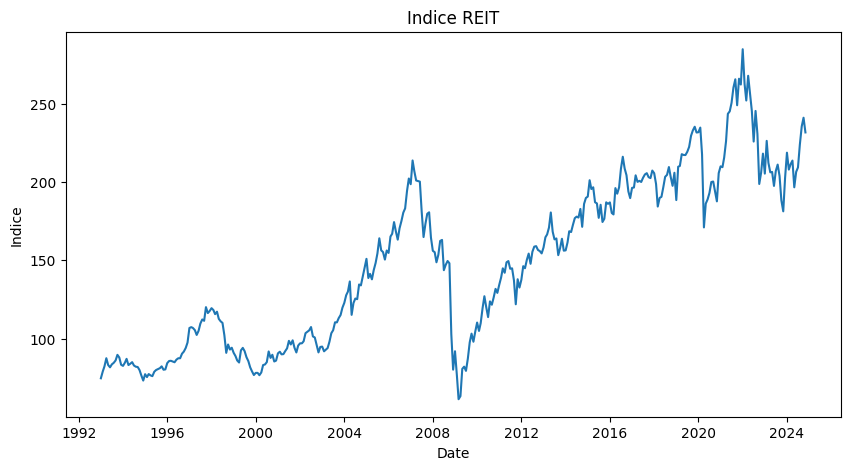

In [14]:
# Canevas
fig, axs = plt.subplots(figsize=(10, 5))

plt.plot(All_REIT)
plt.title('Indice REIT')
plt.xlabel('Date')
plt.ylabel('Indice')


## 1.2 Séparation en données d'entraînement (de 1993-01-01 à 2018-12-01) et de test (de 2019-01-01 à 2024-10-01)

In [15]:
# Séparation en données d'entraînement et de test pour la série des FPI
All_REIT_train = All_REIT[:'2018-12-01']

All_REIT_test = All_REIT['2019-01-01':]

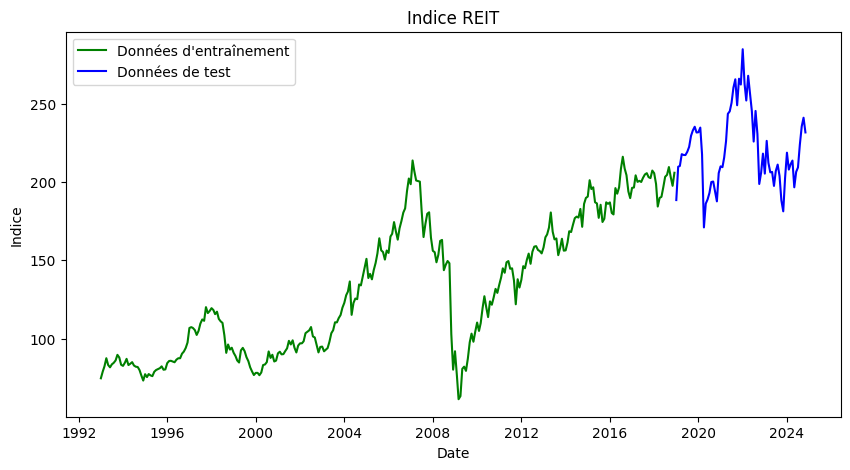

In [16]:
# Canevas
fig, axs = plt.subplots(figsize=(10, 5))

plt.plot(All_REIT_train, 'green', label='Données d\'entraînement')
plt.plot(All_REIT_test, 'blue', label='Données de test')
plt.title('Indice REIT')
plt.xlabel('Date')
plt.ylabel('Indice')
plt.legend()

plt.legend()


# 2. Modélisation ARIMA (données FPI)

## 2.1 Méthode Box-Jenkins

Elle consiste en trois étape: 

1. La première étape consiste à identifier le modèle ARIMA(p,d,q) qui pourrait engendrer la série . Elle consiste, d'abord en transformer la série afin de la rendre stationnaire (le nombre de différenciations détermine l'ordre d'intégration: d), et ensuite d'identifier le modèle ARMA(p,q) de la série transformée avec l'aide du corrélogramme et du corrélogramme partiel. Le graphique des coefficients d'autocorrélation (corrélogramme) et d'autocorrélation partielle (corrélogramme partiel) donnent information sur l'ordre du modèle 

2. La deuxième étape consiste à estimer le modèle ARIMA en utilisant une méthode non linéaire (moindres carrés non-linéaires ou maximum de vraisemblance). Ces méthodes sont appliquées en utilisant les degrés p, d et q trouvés dans l'étape d'identification.

3. La troisième étape consiste à vérifier si le modèle estimé reproduit le modèle qui a engendré les données. Pour cela les résidus obtenus à partir du modèle estimé sont utilisés pour vérifier s'ils se comportent comme des erreurs bruit blanc. 

## 2.1.1 Identification du modèle

> ## a)Détermination de l'ordre de différenciation (d) : Test de Dicker-Fuller

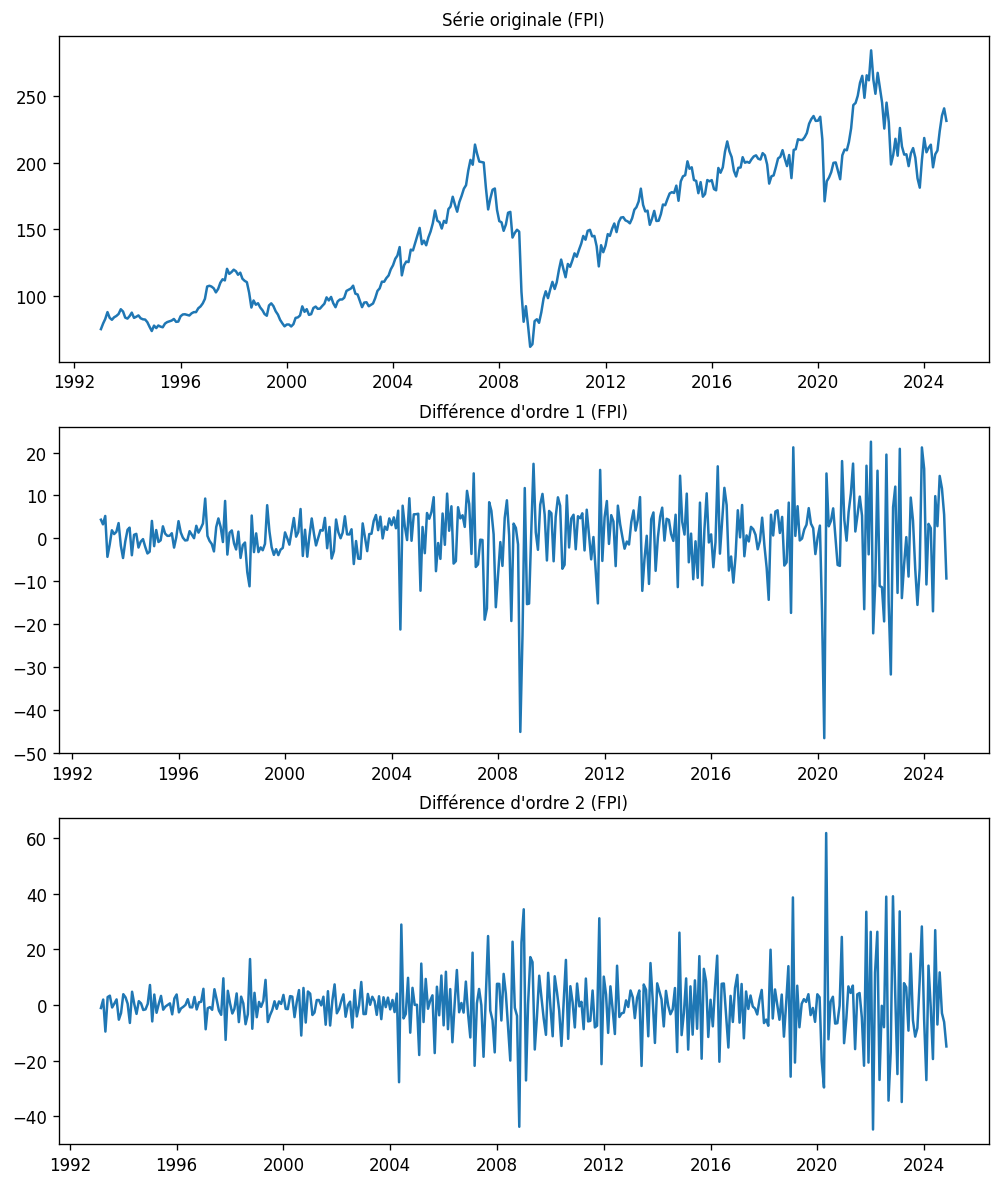

ADF Statistic pour la série originale (FPI)
ADF Statistic: -1.049099
p-value: 0.734938
Valeurs critiques:
	1%: -3.448
	5%: -2.869
	10%: -2.571


ADF Statistic pour la différence d'ordre 1 (FPI)
ADF Statistic: -6.181121
p-value: 0.000000
Valeurs critiques:
	1%: -3.448
	5%: -2.869
	10%: -2.571


ADF Statistic pour la différence d'ordre 2 (FPI)
ADF Statistic: -8.360313
p-value: 0.000000
Valeurs critiques:
	1%: -3.448
	5%: -2.869
	10%: -2.571


In [17]:
# 

plt.rcParams.update({'figure.figsize':(10, 12), 'figure.dpi':120})

# Série originale
fig, axes = plt.subplots(3)
axes[0].plot(All_REIT); axes[0].set_title('Série originale (FPI)', fontsize = 10)

# Première différence
axes[1].plot(All_REIT.diff()); axes[1].set_title('Différence d\'ordre 1 (FPI)', fontsize = 10)

# Deuxième différence
axes[2].plot(All_REIT.diff().diff()); axes[2].set_title('Différence d\'ordre 2 (FPI)', fontsize = 10)

plt.show()

print('ADF Statistic pour la série originale (FPI)')
result = adfuller(All_REIT.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Valeurs critiques:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')

print('ADF Statistic pour la différence d\'ordre 1 (FPI)')
result = adfuller(All_REIT.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Valeurs critiques:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n')

print('ADF Statistic pour la différence d\'ordre 2 (FPI)')
result = adfuller(All_REIT.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Valeurs critiques:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

<p style='text-align: justify;'> On peut voir avec les figures que la série des FPI semble staionnaire dès la première différence. Cela est confirmé par les tests de Dickey-Fuller. En effet, les valeurs de la statistique de Dickey-Fuller sont inférieures à toutes les valeurs critiques à tous les seuils (1%, 5% et 10%) pour les première et deuxième différences. 

On conclut donc que les première et deuxième différence de la série des FPI sont stationnaires. </p>

> ## b) Détermination des termes p et q : Corrélogramme des acf et pacf

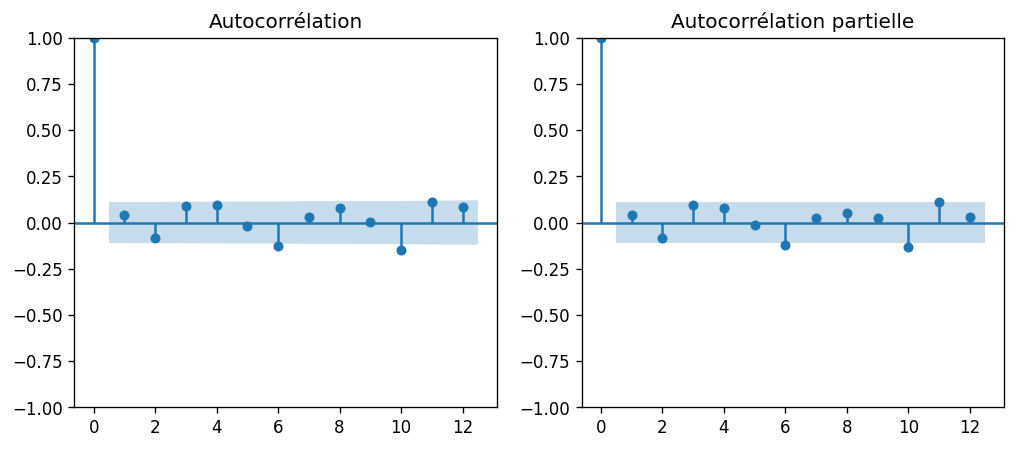

In [18]:
# Corrélogramme acf et pacf première différence

f = plt.figure(figsize=(10,4))

ax1 = f.add_subplot(121)
plot_acf(All_REIT_train.diff().dropna(), ax = ax1, title = 'Autocorrélation', lags=12)

ax2 = f.add_subplot(122)
plot_pacf(All_REIT_train.diff().dropna(), ax = ax2, title = 'Autocorrélation partielle', lags=12)

plt.show()


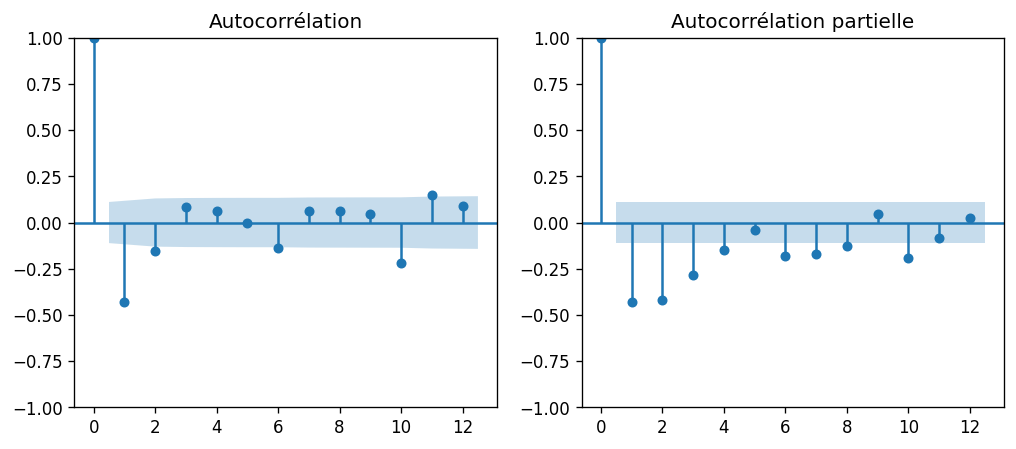

In [19]:
# Corrélogramme acf et pacf deuxième différence

f = plt.figure(figsize=(10,4))

ax1 = f.add_subplot(121)
plot_acf(All_REIT_train.Indice.diff().diff().dropna(), ax = ax1, title = 'Autocorrélation', lags=12)

ax2 = f.add_subplot(122)
plot_pacf(All_REIT_train.Indice.diff().diff().dropna(), ax = ax2, title = 'Autocorrélation partielle', lags=12)

plt.show()

<p style='text-align: justify;'> L'observation des corrélogrammes de la première différence de la série des FPI ne permet de déduire de valeurs significatives.

Par contre, les corrélogrammes de la deuxième différence nous permettent d'avoir des valeurs significatives de 2 pour le terme q et de 4 pour le terme p. 

Au final, le modèle retenu sera un modèle ARIMA(4, 2, 2). </p>

## 2.1.2 Estimation du modèle

In [20]:
# ARIMA(p=1, d=1, q=2) / ARIMA(AR, diff, MA)

arima_model = ARIMA(All_REIT_train.Indice, order = (4, 2, 2))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 Indice   No. Observations:                  312
Model:                 ARIMA(4, 2, 2)   Log Likelihood               -1023.824
Date:                Sat, 16 Nov 2024   AIC                           2061.648
Time:                        11:40:23   BIC                           2087.804
Sample:                    01-01-1993   HQIC                          2072.104
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9227      0.063    -14.674      0.000      -1.046      -0.799
ar.L2         -0.0306      0.070     -0.437      0.662      -0.168       0.107
ar.L3          0.0148      0.068      0.218      0.8

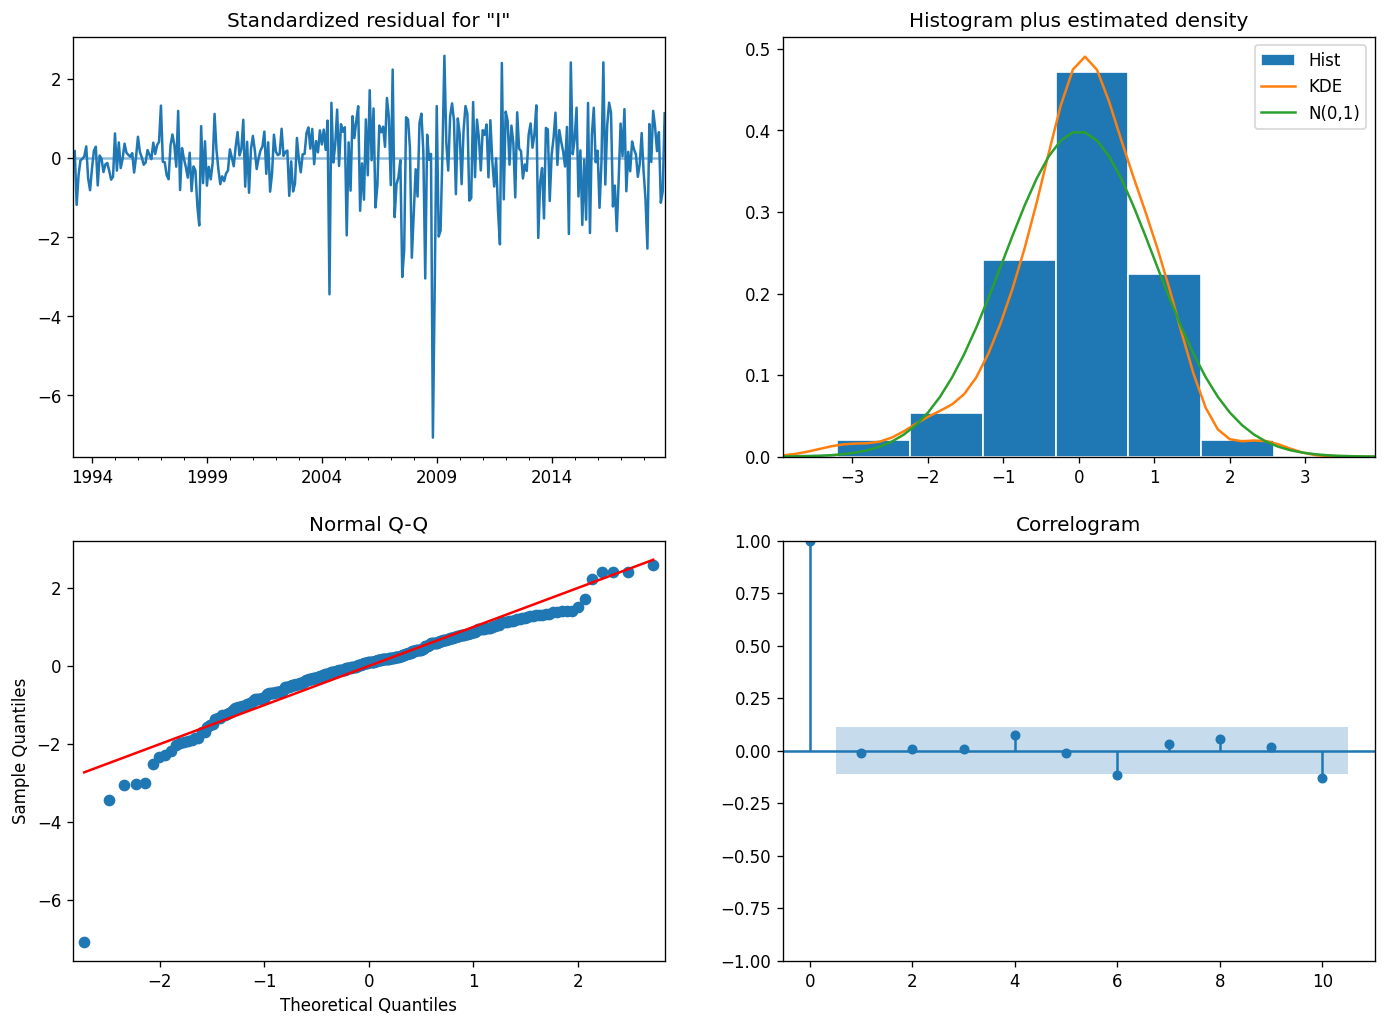

In [21]:
# https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting

model.plot_diagnostics(figsize=(14,10))
plt.show()

## 2.1.3 Vérification du modèle

In [22]:
# Prévision méthode Box-Jenkins
All_REIT_predit = model.forecast(All_REIT_test.shape[0], alpha=0.05)  # 95% confiance
All_REIT_predit = pd.Series(All_REIT_predit, index=All_REIT_test.index)
# lower_series = pd.Series(conf[:, 0], index=All_REIT_test.index)
# upper_series = pd.Series(conf[:, 1], index=All_REIT_test.index)

# Indicateurs d'évaluation du modèle
rmse = np.sqrt(mean_squared_error(All_REIT_test, All_REIT_predit))
mae = mean_absolute_error(All_REIT_test, All_REIT_predit)
mape = mean_absolute_percentage_error(All_REIT_test, All_REIT_predit, multioutput='uniform_average')
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

Test RMSE: 25.246
Test MAE: 21.509
Test MAPE: 0.097


Text(0.5, 1.0, 'Modèle ARIMA(4, 2, 2)')

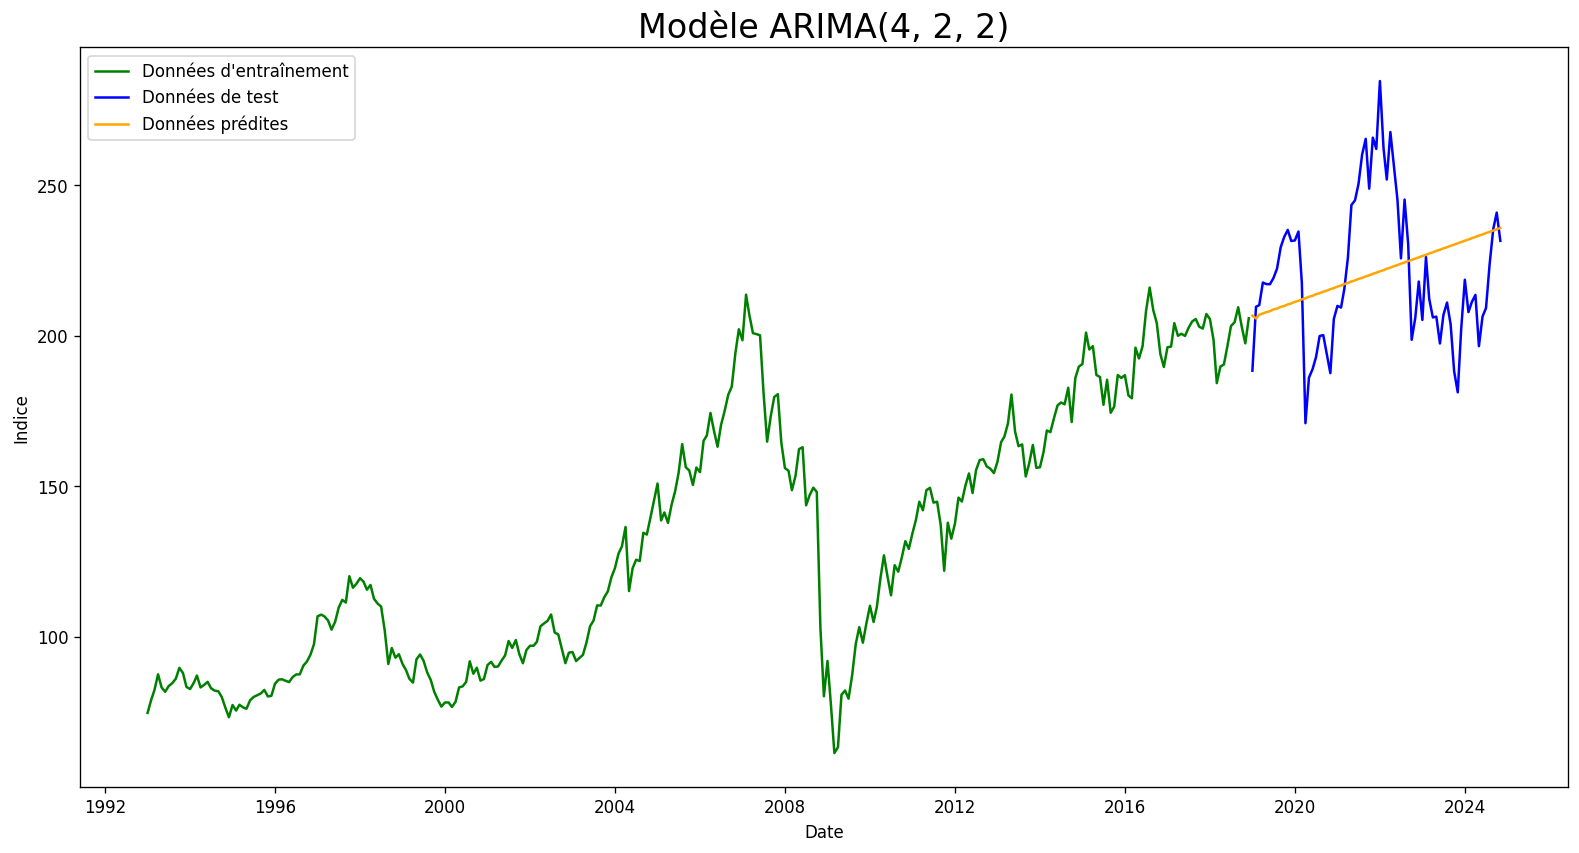

In [23]:
# Comparaison entre les données prédites et les données de test
plt.figure(figsize=(16,8))

plt.xlabel('Date')
plt.ylabel('Indice')
plt.plot(All_REIT_train, 'green', label='Données d\'entraînement')
plt.plot(All_REIT_test, 'blue', label='Données de test')
plt.plot(All_REIT_predit, 'orange', label='Données prédites')
plt.legend()
plt.title('Modèle ARIMA(4, 2, 2)', fontsize = 20)

## 2.2 Utilisation de la méthode automatique de détermination des termes (p, d, q)

## 2.2.1 Identification du modèle

In [24]:
# Utilisation de la méthode automatique de détermination
arima_model_auto =  auto_arima(All_REIT_train, start_p=1, start_q=1,
                          test='adf',
                          max_p=6, max_q=6,
                          m=12,             
                          d=2,          
                          seasonal=False,   
                          start_P=0, 
                          D=1, 
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2252.864, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2190.572, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2250.865, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2131.698, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2106.536, Time=0.11 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=2101.270, Time=0.16 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2102.852, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=2099.273, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=2104.539, Time=0.05 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=2100.854, Time=0

## 2.2.2 Estimation du modèle

In [25]:
arima_model_auto = ARIMA(All_REIT_train.Indice, order = (4, 2, 0))
model_auto = arima_model_auto.fit()
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                 Indice   No. Observations:                  312
Model:                 ARIMA(4, 2, 0)   Log Likelihood               -1044.636
Date:                Sat, 16 Nov 2024   AIC                           2099.273
Time:                        11:40:27   BIC                           2117.956
Sample:                    01-01-1993   HQIC                          2106.741
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7851      0.050    -15.846      0.000      -0.882      -0.688
ar.L2         -0.6943      0.050    -13.859      0.000      -0.792      -0.596
ar.L3         -0.4038      0.052     -7.787      0.0

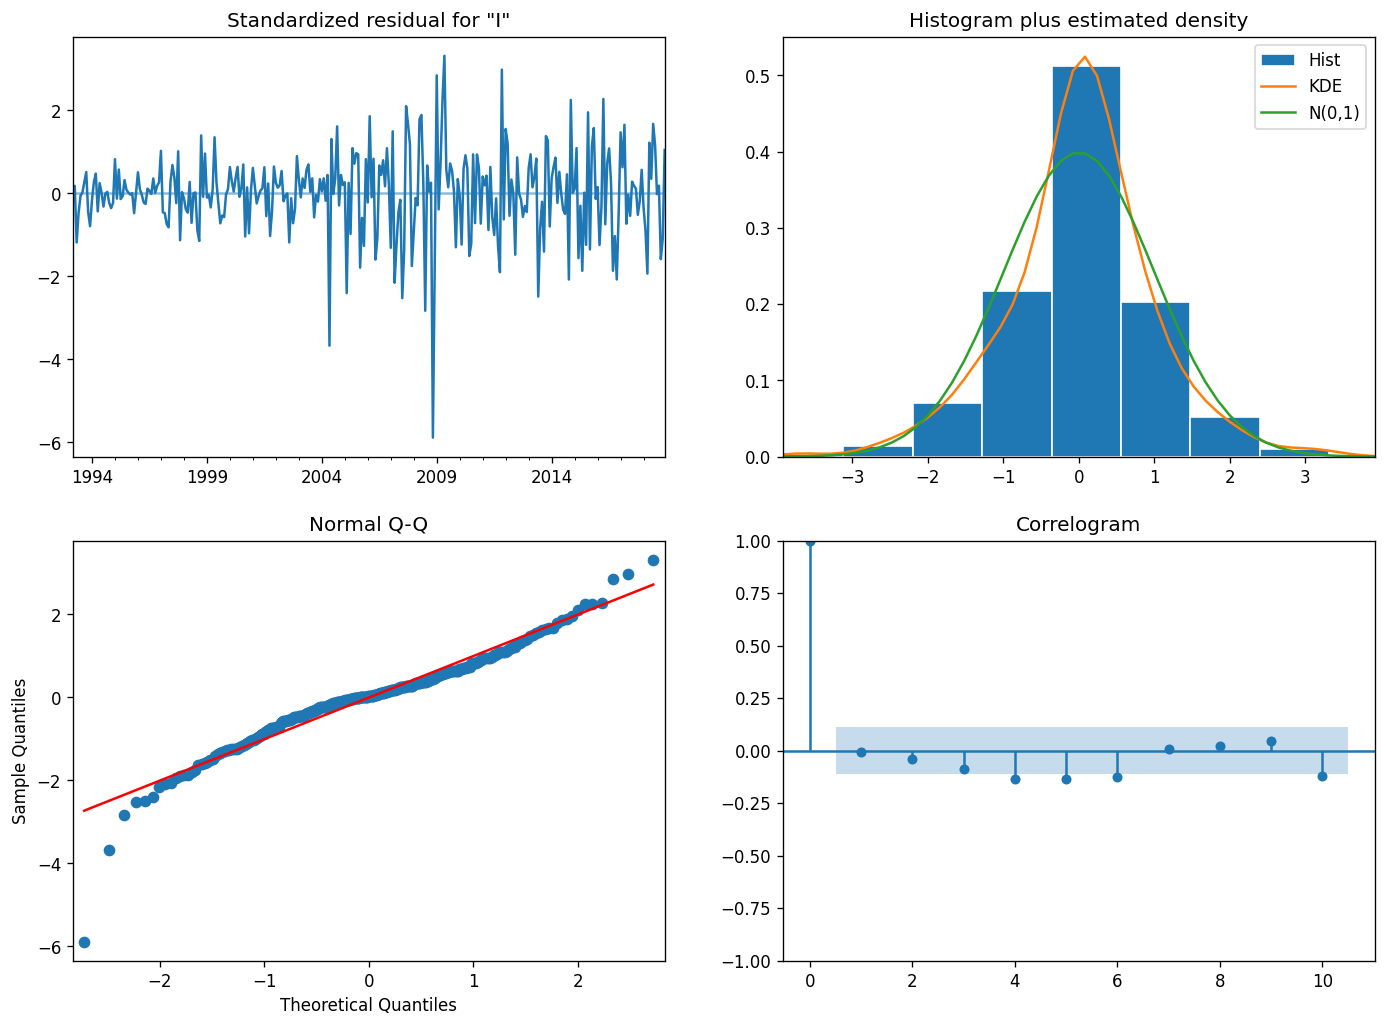

In [26]:
model_auto.plot_diagnostics(figsize=(14,10))
plt.show()

## 2.2.3 Vérification du modèle

In [27]:
# Prévisions modèle automatique
All_REIT_predit_auto = model_auto.forecast(All_REIT_test.shape[0], alpha=0.05)  # 95% confiance
All_REIT_predit_auto = pd.Series(All_REIT_predit_auto, index=All_REIT_test.index)

# Indicateurs d'évaluation du modèle
rmse = np.sqrt(mean_squared_error(All_REIT_test, All_REIT_predit_auto))
mae = mean_absolute_error(All_REIT_test, All_REIT_predit_auto)
mape = mean_absolute_percentage_error(All_REIT_test, All_REIT_predit_auto, multioutput='uniform_average')
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

Test RMSE: 26.579
Test MAE: 23.215
Test MAPE: 0.106


Text(0.5, 1.0, 'Modèle automatique ARIMA(4, 2, 0)')

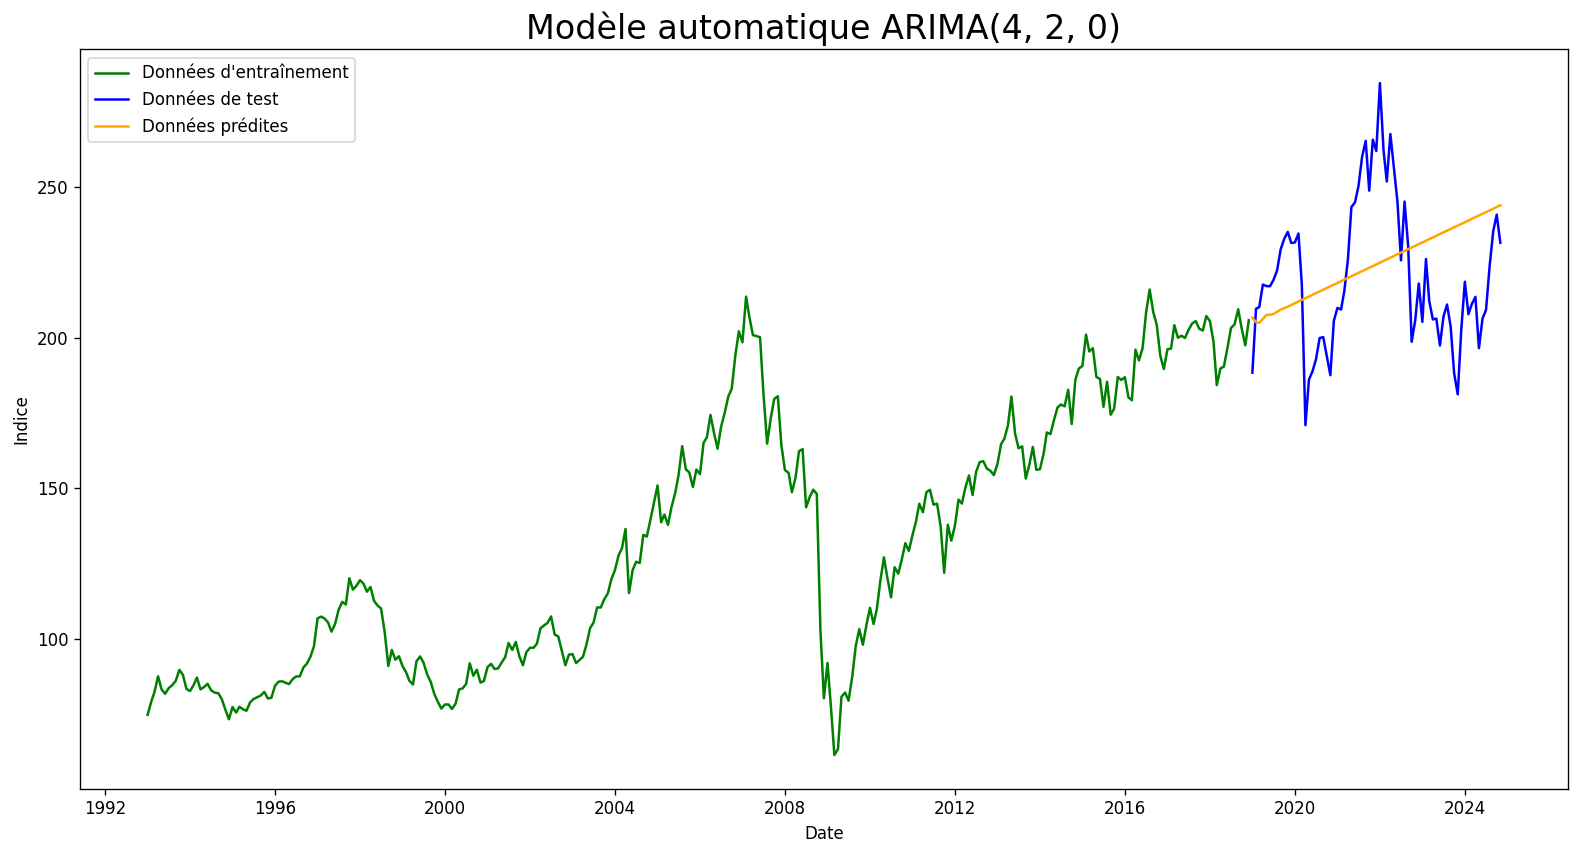

In [28]:
# Comparaison entre les données prédites et les données de test
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Indice')
plt.plot(All_REIT_train, 'green', label='Données d\'entraînement')
plt.plot(All_REIT_test, 'blue', label='Données de test')
plt.plot(All_REIT_predit_auto, 'orange', label='Données prédites')
plt.legend()
plt.title('Modèle automatique ARIMA(4, 2, 0)', fontsize = 20)

# 3. Application de la technique de "Rolling forecast"

Le principe de la technique de "rolling forecast" consiste à :
- faire la prévision pour une période,
- inclure la prévison dans les données d'entraînement,
- refaire l'estimation du modèle avec la nouvelle série obtenue.

## 3.1 Rolling forecast pour le modèle ARIMA(4, 2, 2)

In [29]:
# https://mlpills.dev/time-series/forecasting-in-time-series/

# Définir le modèle et l'horizon
order = (4,2,2)
steps = All_REIT_test.shape[0]

# Initialisation liste des prévisions
predictions = []

# Boucle pour chaque mois
for step in range(steps): 
    
    # Ajouter nouvelle donnée prédite
    All_REIT_train_i = pd.concat([All_REIT_train.Indice, All_REIT_test.Indice[:step]], axis=0)
    
    # Entraînement du modèle
    model_i = ARIMA(All_REIT_train_i.values, order=order).fit()
    
    # Prédire la valeur pour le prochain mois
    pred = model_i.forecast(steps=1)
    
    # Ajouter à la liste des prévisions
    predictions.append(pred)

# Convertir la liste en dataframe
Predictions_manuel_rolling = pd.DataFrame(predictions, 
                                   columns=['Predict'], 
                                   index=All_REIT_test[:steps].index)

# Indicateurs d'évaluation du modèle
rmse = np.sqrt(mean_squared_error(All_REIT_test, Predictions_manuel_rolling))
mae = mean_absolute_error(All_REIT_test, Predictions_manuel_rolling)
mape = mean_absolute_percentage_error(All_REIT_test, Predictions_manuel_rolling, multioutput='uniform_average')
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

Test RMSE: 13.181
Test MAE: 10.178
Test MAPE: 0.047


Text(0.5, 1.0, 'Modèle ARIMA(4, 2, 2) avec rolling')

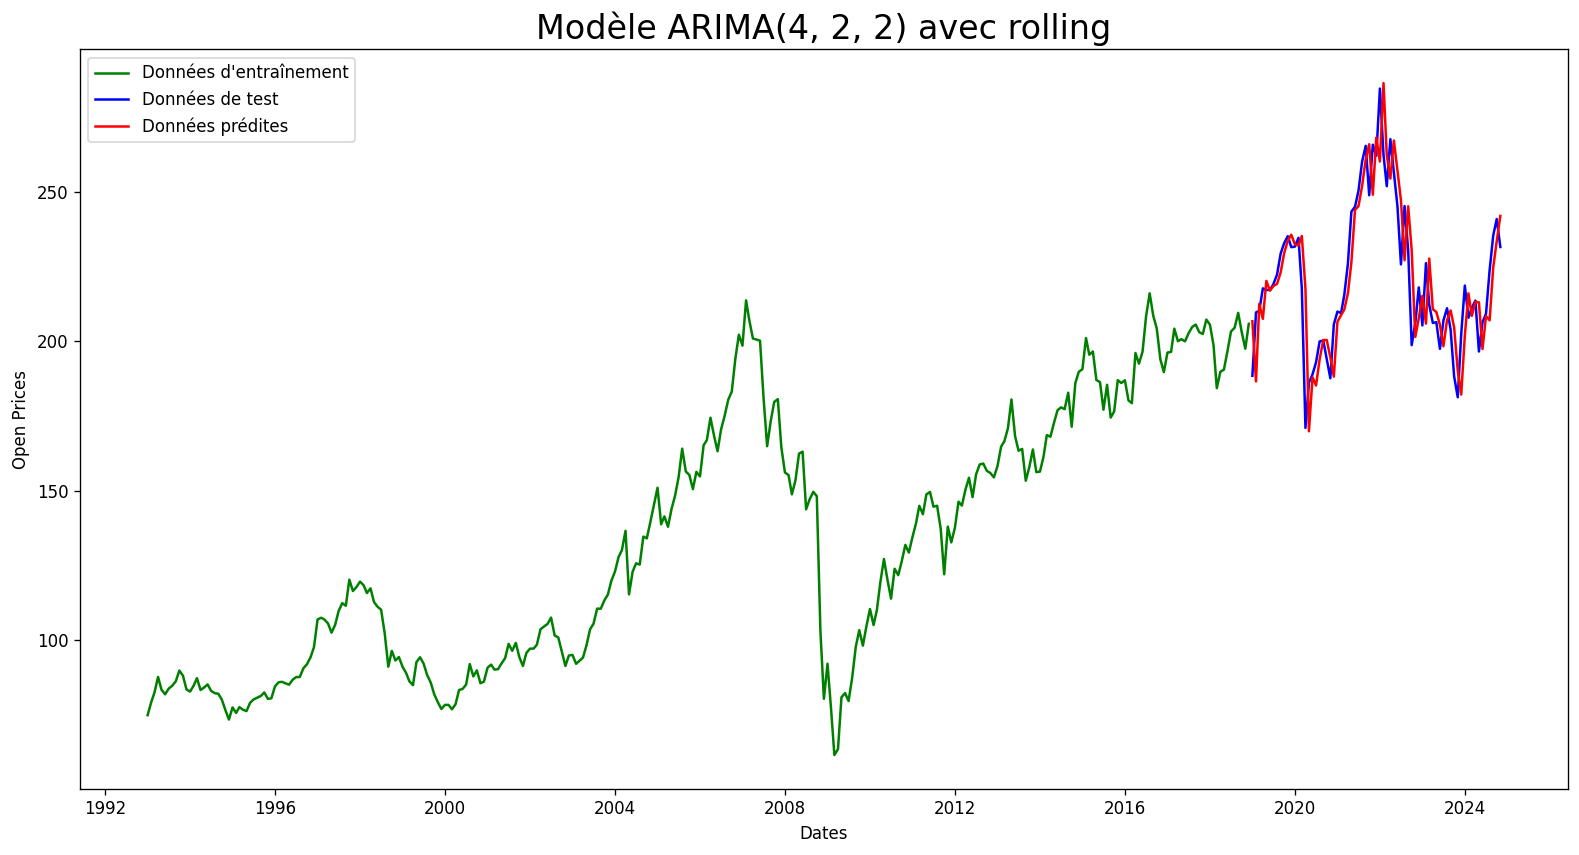

In [30]:
plt.figure(figsize=(16,8))
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(All_REIT_train, 'green', label='Données d\'entraînement')
plt.plot(All_REIT_test, 'blue', label='Données de test')
plt.plot(Predictions_manuel_rolling, 'red', label='Données prédites')
plt.legend()
plt.title('Modèle ARIMA(4, 2, 2) avec rolling', fontsize = 20)

## 3.2 Rolling forecast pour le modèle automatique ARIMA(4, 2, 0)

In [31]:
# https://mlpills.dev/time-series/pour laecasting-in-time-series/

# Définir le modèle et l'horizon
order = (4,2,0)
steps = All_REIT_test.shape[0]

# Initialisation liste des prévisions
predictions = []

# Boucle pour chaque mois
for step in range(steps): 
    
    # Ajouter nouvelle donnée prédite
    All_REIT_train_i = pd.concat([All_REIT_train, All_REIT_test[:step]], axis=0)
    
    # Entraînement du modèle
    model_i = ARIMA(All_REIT_train_i.values, order=order).fit()
    
    # Prédire la valeur pour le prochain mois
    pred = model_i.forecast(steps=1)
    
    # Ajouter à la liste des prévisions
    predictions.append(pred)

# Convertir la liste en dataframe
Predictions_auto_rolling = pd.DataFrame(predictions, 
                                   columns=['Predict'], 
                                   index=All_REIT_test[:steps].index)

In [32]:
# Indicateurs d'évaluation du modèle
rmse = np.sqrt(mean_squared_error(All_REIT_test, Predictions_auto_rolling))
mae = mean_absolute_error(All_REIT_test, Predictions_auto_rolling)
mape = mean_absolute_percentage_error(All_REIT_test, Predictions_auto_rolling, multioutput='uniform_average')
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

Test RMSE: 14.427
Test MAE: 11.361
Test MAPE: 0.053


Text(0.5, 1.0, 'Modèle automatique ARIMA(4, 2, 0) avec rolling')

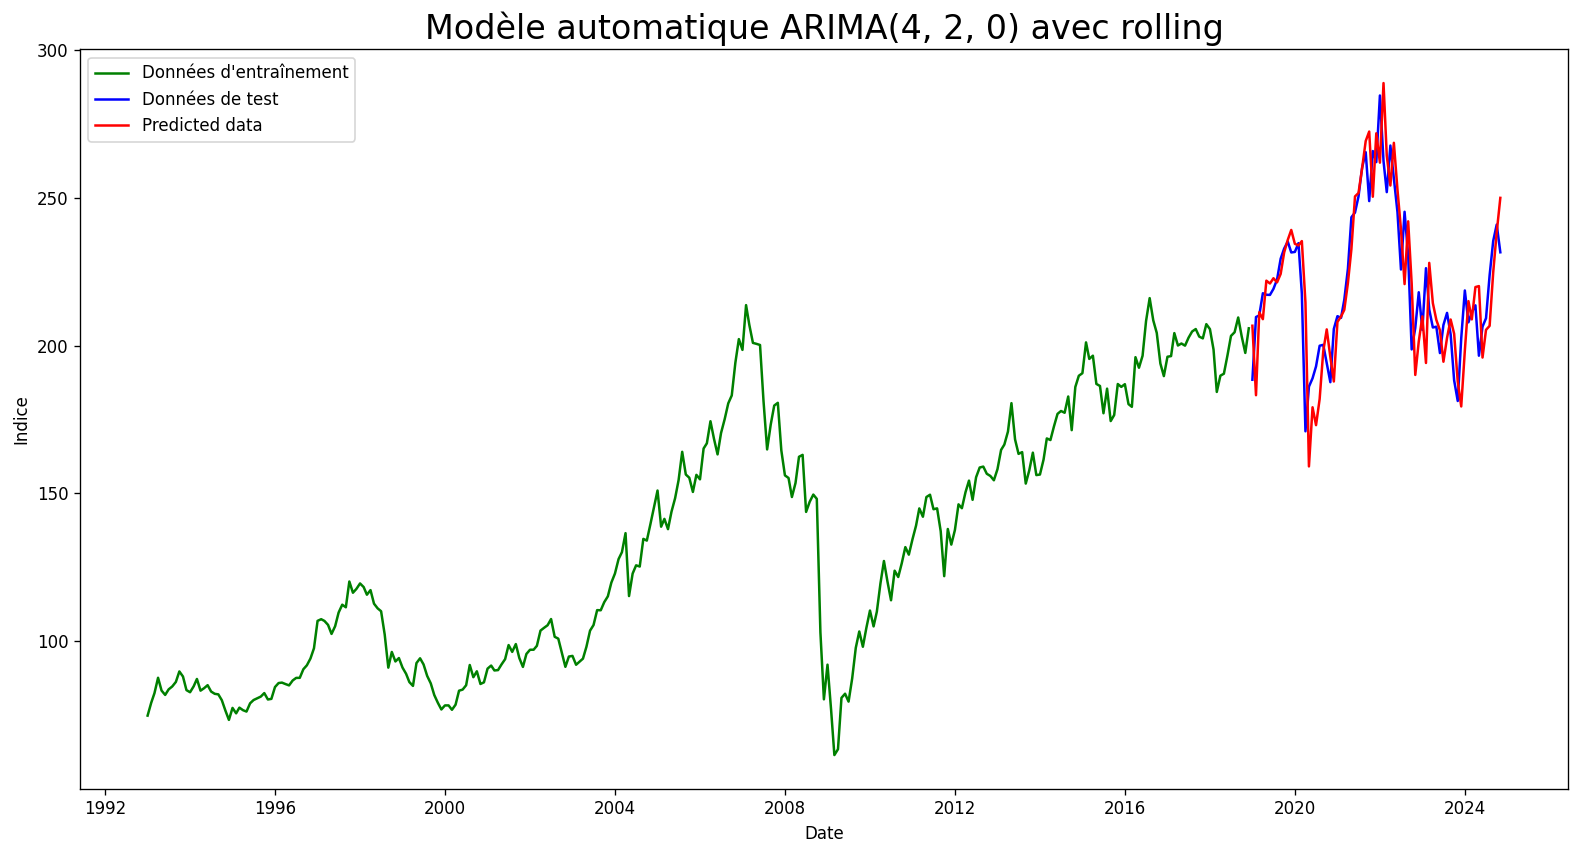

In [33]:
plt.figure(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Indice')
plt.plot(All_REIT_train, 'green', label='Données d\'entraînement')
plt.plot(All_REIT_test, 'blue', label='Données de test')
plt.plot(Predictions_auto_rolling, 'red', label='Predicted data')
plt.legend()
plt.title('Modèle automatique ARIMA(4, 2, 0) avec rolling', fontsize = 20)

# 4. Conclusion

Les figures comparant les données prédites et les données de test montrent clairement que la technique de "rolling forecast" améliore beaucoup la qualité des prévisions. Les modèles de base sans application de cette technique montrent des performances décevantes.

Dans tous les cas, le modèle estimé à partir de la méthodologie de Box-Jenkins performe mieux que le modèle automatique.

 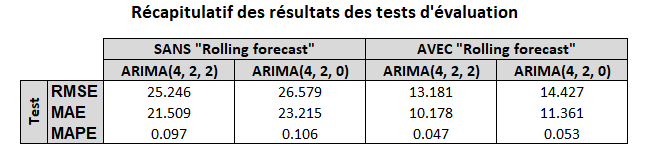


Le récapitulatif des résultats des tests d'évaluation de modèle confirme ce fait. Plus préciséement, l'appication de la technique de "rolling forecast" permet de diviser d'environ de moitié les valeurs des différents tests.